# <center> Function compilation for algorithms in Week 2 </center>

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

### 1. Edit Distance calculation

In [3]:
def edit_distance(a,b): #Calculate edit distance between string 'a' and string 'b'
    if len(a)==0:
        return len(b)
    if len(b)==0:
        return len(a)
    else:
        x=a[-1]
        y=b[-1]
        alpha=a[:-1]
        beta=b[:-1]
        dist_last=0 if x==y else 1
        dist=min(edit_distance(alpha,beta)+dist_last,edit_distance(alpha,b)+1,edit_distance(beta,a)+1)
    return dist        

In [4]:
x='shake spea'
y='Shakespear'
%timeit edit_distance(x,y)


6.07 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
print(edit_distance(x,y))

3


### 2. Edit Distance calculation using  dynamic programming

In [6]:
def edit_recursive(x,y):
    matrix=np.zeros((len(x)+1,len(y)+1))
    matrix[0,0]=0 #Setting empty coordinates to 0
    for i in range(1,len(x)+1):
        matrix[i,0]=matrix[i-1,0]+1
    for i in range(1,len(x)+1):
        for j in range(1,len(y)+1):
            dist_last=0 if x[i-1]==y[j-1] else 1
            matrix[i,j]=min(matrix[i-1,j-1]+dist_last,matrix[i-1,j]+1, matrix[i,j-1]+1)
    return min(matrix[-1])

In [7]:
%timeit edit_recursive('shake spea','Shakespear')

249 µs ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<b>Hence, the edit_distance() takes almost 23k times the edit_recursive()</b>

In [8]:
print(edit_recursive('shake spea','Shakespear'))

2.0


On inspection we realize that it is correct, since the three substitutions need to be performed in the first string are: <br>&nbsp;&nbsp;&nbsp; 1. Change the first 's' to uppercase,<br>&nbsp;&nbsp;&nbsp; 2. Delete the " " character and<br>&nbsp;&nbsp;&nbsp; 3.  Add a "r" at the end of the string

### 3. Global Alignment with penalty=1 across all substitution

In [9]:
def global_alignment(pattern, text): #Expanding recursive edit distance alignment for finding patterns in text
    matrix=np.zeros((len(pattern)+1, len(text)+1))
    matrix[0,:]=0 #keeping the first row pertaining to epsilon completely 0 because we don't know where in the text, the pattern matching start
    for i in range(1,len(pattern)+1):
        matrix[i,0]=matrix[i-1,0]+1
    for i in range(1,len(pattern)+1):
        for j in range(1,len(text)+1):
            dist_last=0 if pattern[i-1]==text[j-1] else 1
            matrix[i,j]=min(matrix[i-1,j-1]+dist_last,matrix[i-1,j]+1, matrix[i,j-1]+1)
    return min(matrix[-1,:]),matrix

In [10]:
matrix1=global_alignment('baaabbbb','bbaddaabaaabbcb')[1]
matrix1

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.],
       [2., 1., 1., 0., 1., 2., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [3., 2., 2., 1., 1., 2., 2., 1., 2., 1., 0., 1., 2., 2., 2., 2.],
       [4., 3., 3., 2., 2., 2., 2., 2., 2., 2., 1., 0., 1., 2., 3., 3.],
       [5., 4., 3., 3., 3., 3., 3., 3., 2., 3., 2., 1., 0., 1., 2., 3.],
       [6., 5., 4., 4., 4., 4., 4., 4., 3., 3., 3., 2., 1., 0., 1., 2.],
       [7., 6., 5., 5., 5., 5., 5., 5., 4., 4., 4., 3., 2., 1., 1., 1.],
       [8., 7., 6., 6., 6., 6., 6., 6., 5., 5., 5., 4., 3., 2., 2., 1.]])

In [11]:
print(' The no. of substitutions to be done are:',global_alignment('baaabbbb','bbaddaabaaabbcb')[0])

 The no. of substitutions to be done are: 1.0


In [12]:
def find_index(matrix,pattern,text): #matrix = completed DP matrix
    vals=min(matrix[-1,:]) #Find the minimum value in the last row
    x_max=np.squeeze(np.where(matrix[-1,:]==vals)) #Find the column index where 'vals' is located. Basically, anything to the right of x_max in the matrix is ignored in this operation
    t1=text[:x_max]
    x=x_max
    y=len(pattern) # Basically our area of focus is the slice of the matrix matrix[:,:x_max]
    while x>=0 and y>0:
        diff=0 if t1[x-1]==pattern[y-1] else 1
        check1=matrix[y-1,x-1]-diff
        check2=matrix[y-1,x]-1
        check3=matrix[y,x-1]-1
        r=np.argmin([check1,check2,check3])
        if r==0:
            x-=1
            y-=1
        if r==1:
            y-=1
        if r==2:
            x-=1   
    return text[x-1:],x-1

In [13]:
text_locate, offset=find_index(matrix1,'baaabbbb','bbaddaabaaabbcb')
print('The text found is :',text_locate ,' and it is found at offset ',offset, 'in the text')

The text found is : baaabbcb  and it is found at offset  7 in the text


### 4. Global Alignment with variable penalty across mismatches and indels (insertion-deletions)

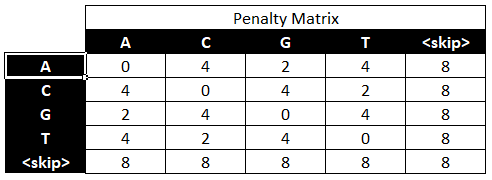

We now ascribe different penalties to various substitutions e.g. replacing an "A" with a "G" has a lower penalty than an "A" with a "C" or a "T". Similarly, the highest penalties are awarded where a skip is done i.e. we need to do an insertion or deletion since those are very rare in the natural environment

In [14]:
bases=['A','C','G','T','s'] #This is the order in which we are making the penalty table. 's' stands for a skip
penalty=np.empty((len(bases),len(bases)))
penalty[0]=np.array([0,4,2,4,8])
penalty[1]=np.array([4,0,4,2,8])
penalty[2]=np.array([2,4,0,4,8])
penalty[3]=np.array([4,2,4,0,8])
penalty[4]=np.array([8,8,8,8,8])
penalty=np.array(penalty).astype('int32')
print(penalty)

[[0 4 2 4 8]
 [4 0 4 2 8]
 [2 4 0 4 8]
 [4 2 4 0 8]
 [8 8 8 8 8]]


In [15]:
def global_alignment_penalty(pattern, text,penalty):
    matrix=np.zeros((len(pattern)+1, len(text)+1))
    for i in range(1,len(pattern)+1):
        matrix[i,0]=matrix[i-1,0]+penalty[bases.index(pattern[i-1]),-1] #populating the first row .This will be prev cell + penalty for a skip (since we are mapping a base to an empty string)
    for i in range(1,len(text)+1):
        matrix[0,i]=matrix[0,i-1]+penalty[-1,bases.index(text[i-1])] #populating the first column .This will be prev cell + penalty for skipping the previous letter (since we are mapping a base to an empty string)
    for i in range(1,len(pattern)+1):
        for j in range(1,len(text)+1):
            dist_last=penalty[bases.index(pattern[i-1]),bases.index(text[j-1])] #substitution
            dist_hor=penalty[-1,bases.index(text[j-1])]  # So if the previous letter in the
            dist_ver=penalty[bases.index(pattern[i-1]),-1]
            matrix[i,j]=min(matrix[i-1,j-1]+dist_last,matrix[i-1,j]+dist_ver, matrix[i,j-1]+dist_hor)
    return matrix[-1,-1],matrix
    

In [16]:
total_penalty,matrix_penalty=global_alignment_penalty('TACCAGATTCGA', 'TATCAGATTCGA',penalty)
print(total_penalty)
print(matrix_penalty)

2.0
[[ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80. 88. 96.]
 [ 8.  0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80. 88.]
 [16.  8.  0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80.]
 [24. 16.  8.  2.  8. 16. 24. 32. 40. 48. 56. 64. 72.]
 [32. 24. 16. 10.  2. 10. 18. 26. 34. 42. 48. 56. 64.]
 [40. 32. 24. 18. 10.  2. 10. 18. 26. 34. 42. 50. 56.]
 [48. 40. 32. 26. 18. 10.  2. 10. 18. 26. 34. 42. 50.]
 [56. 48. 40. 34. 26. 18. 10.  2. 10. 18. 26. 34. 42.]
 [64. 56. 48. 40. 34. 26. 18. 10.  2. 10. 18. 26. 34.]
 [72. 64. 56. 48. 42. 34. 26. 18. 10.  2. 10. 18. 26.]
 [80. 72. 64. 56. 48. 42. 34. 26. 18. 10.  2. 10. 18.]
 [88. 80. 72. 64. 56. 50. 42. 34. 26. 18. 10.  2. 10.]
 [96. 88. 80. 72. 64. 56. 50. 42. 34. 26. 18. 10.  2.]]


### 5. Overlaps

In [17]:
def overlap(a,b,minlength=3): #Find if prefix of 'b' is in suffix of 'a'
    start=0
    while True:
        start = a.find(b[:minlength],start)
        if start==-1:
            return 0
        if b.startswith(a[start:]): ###Only need the space where b starts
            return len(a)-start
        start+=1   

In [18]:
print(overlap('bbaa','bbaaabbaaegaa',minlength=1))
print(overlap('TTACGT','CGTACCGTTTACGTTTACGT',3))

4
3


In [19]:
from itertools import permutations #<---- new library I learnt this time :)
def naive_overlap(reads_list, min_length=3):
    overlaps_dict={}
    for a,b in permutations(reads_list, 2):
        print(a,b)
        overlap_length=overlap(a,b,min_length)
        if overlap_length>0:
            overlaps_dict[(a,b)]=overlap_length
    return overlaps_dict
            

In [20]:
reads=['ACGGATGATC','GATCAAGT','TTCACGGA']
print(naive_overlap(reads,3))

ACGGATGATC GATCAAGT
ACGGATGATC TTCACGGA
GATCAAGT ACGGATGATC
GATCAAGT TTCACGGA
TTCACGGA ACGGATGATC
TTCACGGA GATCAAGT
{('ACGGATGATC', 'GATCAAGT'): 4, ('TTCACGGA', 'ACGGATGATC'): 5}
